### Importing needed packages and defining utility methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
def kde_plot(data, feature):
    plt.figure(figsize=(8, 3))
    plt.title(f"KDE for {feature}")
    ax0 = sns.kdeplot(data[data['Churn'] == 'No'][feature].dropna(), color= 'royalblue', label= 'Churn: No')
    ax1 = sns.kdeplot(data[data['Churn'] == 'Yes'][feature].dropna(), color= 'darkred', label= 'Churn: Yes')
    
def cat_plot(data, feature):
    plt.figure(figsize=(8, 3))
    plt.title(f"Cat plot for {feature}")
    tmp_df = data[feature].groupby(data['Churn']).value_counts(normalize=True).rename("percent").reset_index()
    sns.barplot(data=tmp_df, x=feature, y='percent', hue='Churn')
    

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

### Data loading and cleaning

In [3]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Let's check how many empty cells we have:

In [4]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There's no column with NaN values, so let's look to the types and unique values for categorical features

In [5]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
for col in data.select_dtypes(include=["object"]):
    print(col, data[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn ['No' 'Yes']


'TotalCharges' type is object, but after checking its values it seems to be a bug. Also, in dataset description there is information that it is "total amount charged to the customer". Let's try to convert it to numerical.

In [7]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [8]:
data['TotalCharges'].isnull().sum()

11

Now there are 11 examples with NaNs instead of total amount charged, let's see these examples

In [9]:
data[data['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


As we can see, the 'tenure' feature (which is literally the umber of months the customer has stayed with the company) for all rows is equal to 0, which means that those clients have just signed the contract. We can do both things: remove those rows (because I think there is no probability to churn if you just signed the contract) or set TotalCharges to 0. I will follow the second approach.

In [10]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

Finally, let's see types of features once again

In [11]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [12]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [13]:
len(data[data['Churn'] == "Yes"]) * 100 / len(data)

26.536987079369588

To sum up this part, we have 16 categorical features: 5 binary ones (gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling), 9 with 3 possible values (MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract) and one, PaymentMethod with 4 unique values; 3 numeric (tenure, MonthlyCharges and TotalCharges) and target variable 'Churn' which has 2 possible values, so the task is the binary classification. The dataset is imbalanced, the positive class is only 26.5%.

### Outliers analysis

Let's check if there are any outliers in numerical features

In [14]:
binary_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
categorical_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                        'Contract', 'PaymentMethod']
numerical_features =  ['tenure', 'MonthlyCharges', 'TotalCharges']

In [15]:
data[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


At the first glance nothing looks suspicious, let's check it by using IQR and some plots

/home/maciej/Pulpit/rekrutacja/Promo.com/churn_analysis_venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


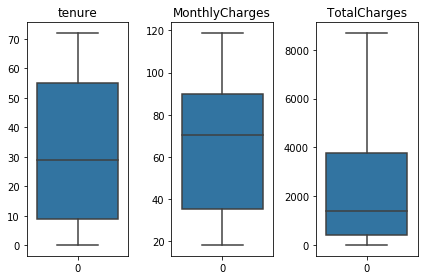

In [16]:
fig, ax = plt.subplots(1, 3)
for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=data[feature], ax=ax[idx]).set_title(feature)
plt.tight_layout()
fig.show()

The hypothesis was true: there are no points below the lower bound ($Q1 - 1.5 * IQR$) and above the upper bound ($Q3 + 1.5 * IQR$)

### Feature analysis

Let's check the influence of features on target variable. First, by using KDE plots for numerical features.

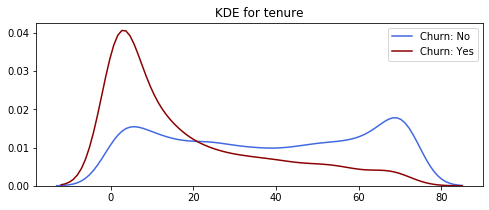

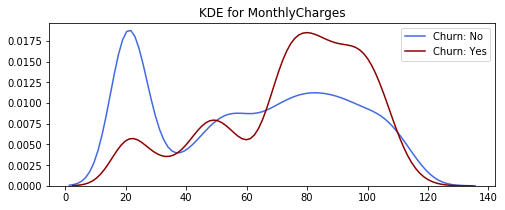

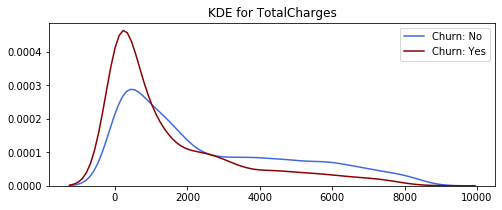

In [17]:
for col in numerical_features:
    kde_plot(data, col)

We can see that recent clients are more likely to churn and those who pay high monthly charges. These two features, tenure and MonthlyCharges are probably important in prediction.

Let's check how categorical features influence target variable

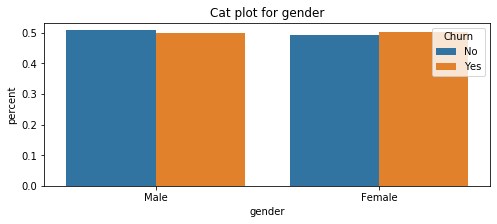

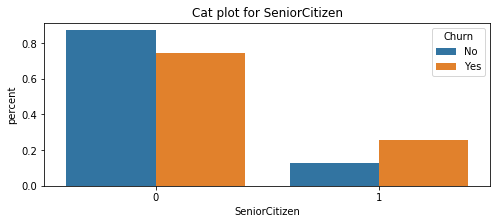

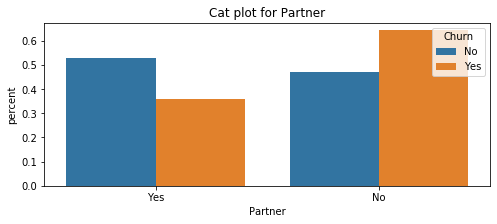

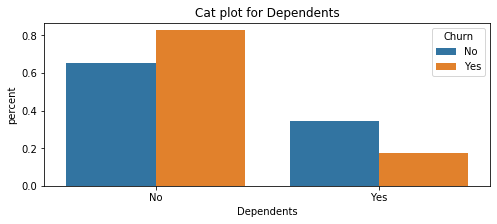

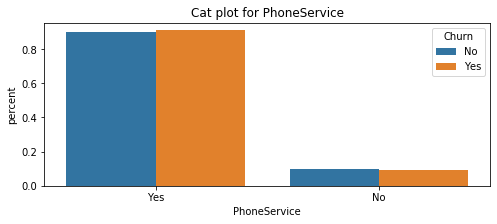

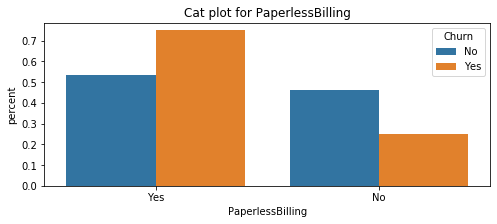

In [18]:
for col in binary_features:
    cat_plot(data, col)

We can see that the churn percent is almost equal for men and women. The higher percentage of seniors decide to resign from the service. Customers with partners and dependents have lower churn rate compared to those who don't have them. The percentage of churn is higher in case of people who have paperless billing option. PhoneService seems to not be important in predicting churn.

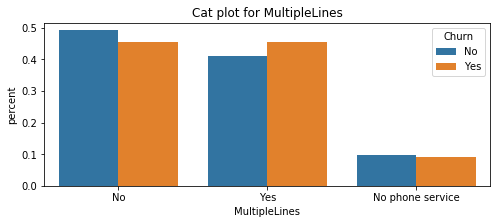

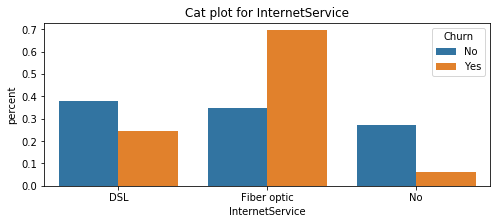

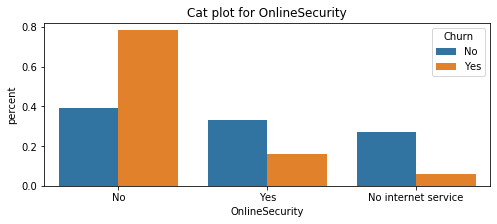

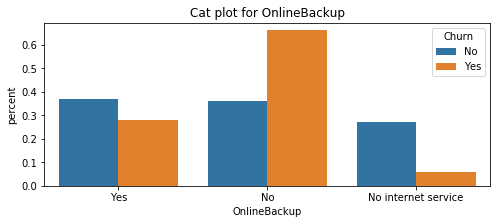

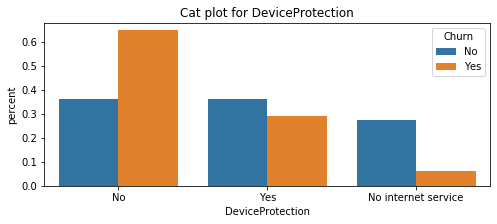

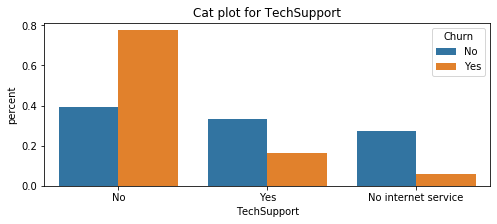

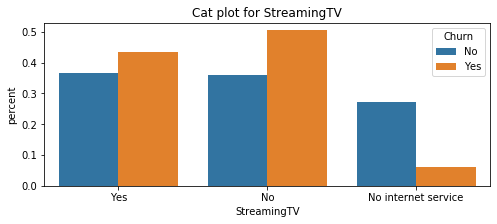

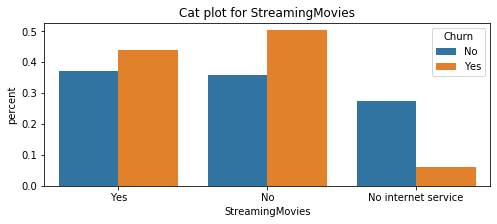

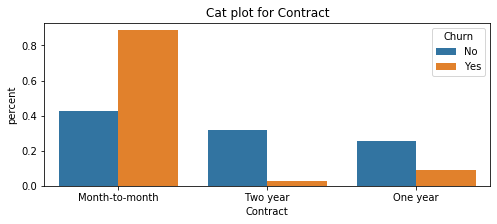

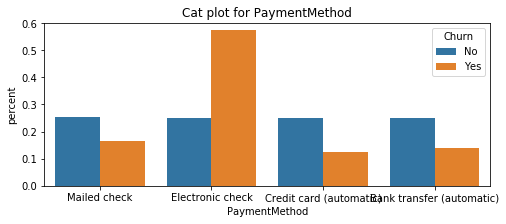

In [19]:
for col in categorical_features:
    cat_plot(data, col)

People with multiple lines are more likely to churn, but the difference is small. However, the rate is higher for those with fiber opric InternetService. Just like those without OnlineSecurity, OnlineBackup and TechSupport and DeviceProtection. Many customers with month-to-month type of contract have left the company. Those with Electronic check PaymentMethod are more likely to churn.

### Data transforming

In [20]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == "Female" else 0)
data['Partner'] = data['Partner'].apply(lambda x: 1 if x == "Yes" else 0)
data['Dependents'] = data['Dependents'].apply(lambda x: 1 if x == "Yes" else 0)
data['PhoneService'] = data['PhoneService'].apply(lambda x: 1 if x == "Yes" else 0)
data['PaperlessBilling'] = data['PaperlessBilling'].apply(lambda x: 1 if x == "Yes" else 0)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == "Yes" else 0)

In [21]:
target_variable = data['Churn']
data = data.drop(['customerID', 'Churn'], axis=1)

In [22]:
data.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65


### Modelling

Numerical features will be standarized and categorical ones - one-hot encoded.

In [23]:
transform = FeatureUnion([
    ("numerical_features", Pipeline([
        ("selector", ItemSelector(numerical_features)),
        ("scaler", StandardScaler())
    ])),
    ("binary_features", Pipeline([
        ("selector", ItemSelector(binary_features))
    ])),
    ("categorical_features", Pipeline([
        ("selector", ItemSelector(categorical_features)),
        ("encoder", OneHotEncoder())
    ]))
])

models = [
    GaussianNB(), 
    LinearSVC(class_weight='balanced'), 
    XGBClassifier()
]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, target_variable, test_size=0.2, stratify=target_variable, random_state=42)

In [25]:
baseline = [0] * len(y_test)
print("Baseline:")
print(classification_report(y_test, baseline))

Baseline:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/home/maciej/Pulpit/rekrutacja/Promo.com/churn_analysis_venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
X_train = transform.fit_transform(X_train)
X_test = transform.transform(X_test)

In [27]:
for model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    except TypeError:
        # NB does not support sparse data
        model.fit(X_train.todense(), y_train)
        y_pred = model.predict(X_test.todense())

    print(f"Model {model.__class__.__name__}:") 
    print(classification_report(y_test, y_pred))
    print()

Model GaussianNB:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1035
           1       0.45      0.84      0.59       374

    accuracy                           0.69      1409
   macro avg       0.69      0.74      0.67      1409
weighted avg       0.79      0.69      0.71      1409




/home/maciej/Pulpit/rekrutacja/Promo.com/churn_analysis_venv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409


Model XGBClassifier:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409




Two models, linear SVM and XGBoost have outperformed the baseline in case of accuracy and F1 score.

### Future

Some ideas what to do with that next:
* choose only important features,
* checking more classifiers, with different combinations of parameters (eg. using GridSearch),
* dealing with imbalanced target class:
    * add more positive data,
    * downsampling (it could help, but it could also parturb importance of features),
    * add weighted loss
* create ensemble model